# Spam Detection

Introduction

I have  always been fascinated by Google's spam detection system in Gmail, where it can seemingly effortlessly decide whether incoming emails are spam and therefore not worthy of our limited attention.

I seek to recreate such a spam detection system, but on sms messages. I will use a models to know performance.
 
The model Im goning to us ein thios project: Logistic Regression Model with ngrams parameters

Using a train-test split, the logistic model were put through the stages of X_train vectorization, model fitting on X_train and Y_train, make some predictions and generate the respective confusion matrices and area under the receiver operating characteristics curve for evaluation. (AUC-ROC)

# The Data:-

The data was obtained from GIThub Spam Dection, alternatively I have taken a reference for some of the sites. In total, the data set has 5572 rows, and 2 columns: spam or ham indicating it’s spam status and the message’s text. I found it quite funny how the text is quite relatable.

Definitions: Spam refers to spam messages as they are commonly known,

ham refers to non-spam messages.



# Load libraries

In [3]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import seaborn as sns
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from imblearn.pipeline import Pipeline

import sklearn.metrics as metrics

%matplotlib notebook

In [4]:
# Downloading the csv file from your GitHub account
# the url is the raw version of the file on GitHub
url = "https://raw.githubusercontent.com/Conero007/Spam-Detection/master/spam.csv"
download = requests.get(url).content
# Reading the downloaded content and turning it into a pandas dataframe
df = pd.read_csv(io.StringIO(download.decode('utf-8')))

In [5]:
df.head() # first five rows 

,text,target
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


Target:

Spam: message is spam


ham: message is not spam

In [6]:
df.count() #CHECKIING FOR THE COUNT OF DATA.

text      5572
target    5572
dtype: int64

In [7]:
#check for missing da
df.isnull().sum()

text      0
target    0
dtype: int64

In [8]:
#check for duplicated
sum(df.duplicated())


403

In [9]:
# Drop duplicates
df.drop_duplicates(inplace = True)
len(df)

5169

there are around 403 duplicates and all of them are droped,then left over are 5169 instances.

then we go on to the further process

# Inspect Data(ExploratoryData Analysis [EDA])

In [10]:
df.info() # Determine data types

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5169 non-null   object
 1   target  5169 non-null   object
dtypes: object(2)
memory usage: 121.1+ KB


In [11]:
#total number of word in text
print(df['text'].apply(lambda x: len(x.split(' '))).sum()) 

79892


converting target coloumn into:

"0" = ham(not spam)  

"1" = spam

In [12]:
df['target'] = df['target'].map({'ham':0,'spam':1}) #convert in the target into "1"-spam and "0"=not spam

Elobrating the coloum so that we can able to further process

In [13]:
pd.set_option('max_colwidth',220)    # elobrating the cloumn. 
df.head()

,text,target
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives around here though",0


In [14]:
df['target'].value_counts() #count of not spam and spam

0    4516
1     653
Name: target, dtype: int64

<IPython.core.display.Javascript object>


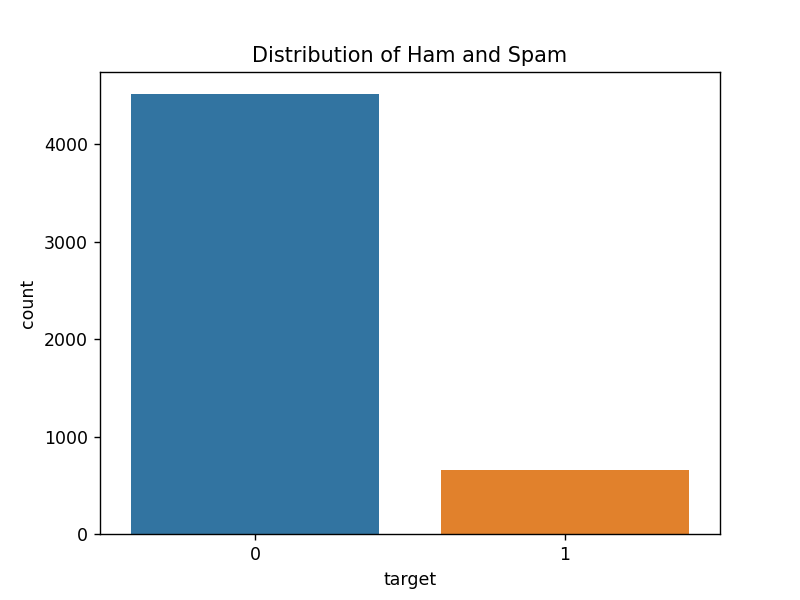

In [15]:
#plotting graph for distribution

sns.countplot(x = "target", data = df)           # plotting count plot with target column
plt.title('Distribution of Ham and Spam')    
plt.savefig('count_plot') 

Lets check the length of each message and see if using length we can diffrentiate between ham and spam


In [16]:
df.describe()

,target
count,5169.000000
mean,0.126330
std,0.332253
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<IPython.core.display.Javascript object>


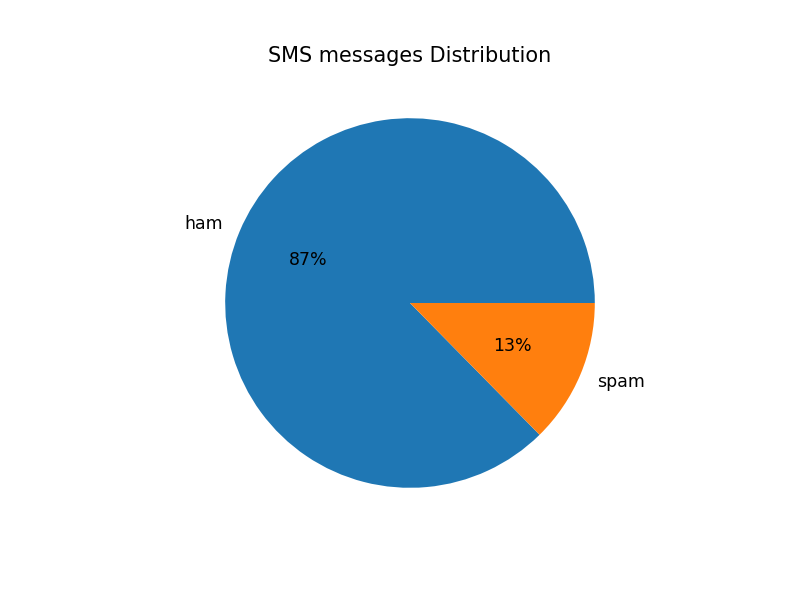

In [17]:
sms = pd.value_counts(df["target"], sort=True)
sms.plot(kind="pie", labels=["ham", "spam"], autopct="%1.0f%%")

plt.title("SMS messages Distribution")
plt.ylabel("")
plt.show()

clearly show that the ratio of not spam to spam instances is 87:12

now let us know the Length of the Text messages:

In [18]:
# Add a field to our dataframe with the length of each message
df['Length'] = df['text'].apply(len)
df.head()

,text,target,Length
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",0,111
1,Ok lar... Joking wif u oni...,0,29
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,1,155
3,U dun say so early hor... U c already then say...,0,49
4,"Nah I don't think he goes to usf, he lives around here though",0,61


<IPython.core.display.Javascript object>


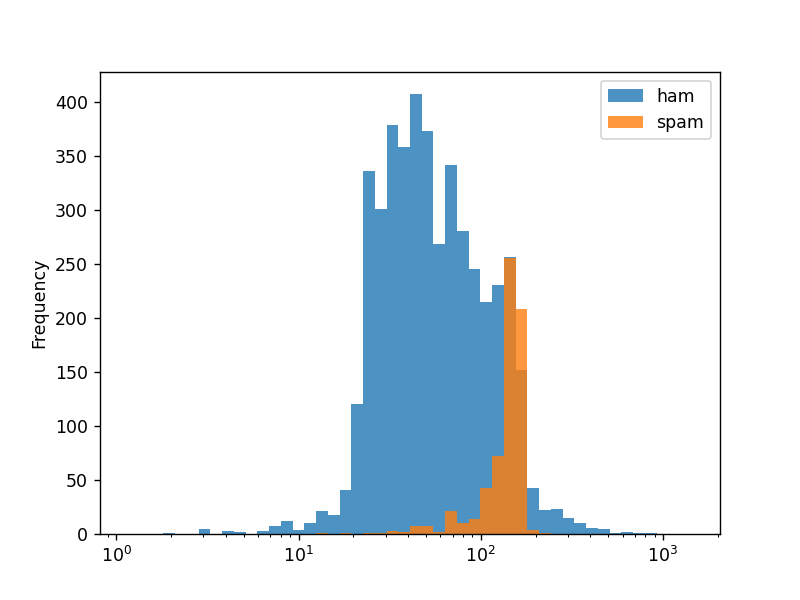

In [19]:
# Lets plot the length of the message

plt.xscale('log')
bins= 1.16**np.arange(1,50)

df[df['target']==0]['Length'].plot(kind='hist',bins=bins,alpha=0.8)
df[df['target']==1]['Length'].plot(kind='hist',bins=bins,alpha=0.8)

plt.legend(['ham','spam'])
plt.show()

Clearly, spam messges are longer in length as compared to ham messages

# Data Cleaning


Punctuation



In [20]:
# Let's remove the punctuation
import string

# Function to remove the punctuation
def remove_punct(text):
    new_text = ''
    for char in text:
        if char in string.punctuation:
            continue
        else:
            new_text += char
    return new_text


# applying the above function on single message to check if it works
single_message = df['text'][0]

print('message before removing the punctuation:')
print('\n')
print(single_message)
print('\n')
print('message after removing the punctuation:')
print()
print(remove_punct(single_message))

message before removing the punctuation:


Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


message after removing the punctuation:

Go until jurong point crazy Available only in bugis n great world la e buffet Cine there got amore wat


In [21]:
# Let's apply the above function to all the messages
df['text'] = df['text'].apply(remove_punct)

Stemming

In [22]:
# To perform stemming we will use Porterstemmer from nltk
from nltk.stem.porter import PorterStemmer
p_stemmer = PorterStemmer()

# Function to do the stemming
def stemming(text):
    text = text.split(' ') # to seperate the words
    text = [p_stemmer.stem(word) for word in text]
    
    return text
    
# Lets test it on single message
single_message = df['text'][0]

print('message before stemming:')
print('\n')
print(single_message)
print('\n')
print('message after stemming:')
print()
print(stemming(single_message))

message before stemming:


Go until jurong point crazy Available only in bugis n great world la e buffet Cine there got amore wat


message after stemming:

['go', 'until', 'jurong', 'point', 'crazi', 'avail', 'onli', 'in', 'bugi', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amor', 'wat']


Check how 'crazy' became 'crazi' , 'only' became 'onli' and 'amore' became 'amor', the upper case words also chnage to lower case. We will keep the message in the form of list for sometime. We will convert it back to text for creating the model

In [23]:
# Let's apply the above function to all the messages
df['text'] = df['text'].apply(stemming)

Stopwords

In [24]:
# Stopwords can be is,are,the etc.
# We will use stopword method from nltk corpus library
from nltk.corpus import stopwords

# function to remove the stopword
def remove_stopwords(text):
    text = [word for word in text if word not in stopwords.words('english')]   
    # converting the list back to text
    return ' '.join(text)

# Let's test it on single message
single_message = df['text'][0]

print('message before removing the stopwords:')
print('\n')
print(single_message)
print('\n')
print('message after removing the stopwords:')
print()
print(remove_stopwords(single_message))

message before removing the stopwords:


['go', 'until', 'jurong', 'point', 'crazi', 'avail', 'onli', 'in', 'bugi', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amor', 'wat']


message after removing the stopwords:

go jurong point crazi avail onli bugi n great world la e buffet cine got amor wat


'until','in','there' are removed from the message.

In [25]:
# Let's apply the above function to all the messages
df['text'] = df['text'].apply(remove_stopwords)

In [26]:
#for counting frequently occurence of spam and ham.

count1 = Counter(" ".join(df[df['target']==0]["text"]).split()).most_common(30)
data1 = pd.DataFrame.from_dict(count1)
data1 = data1.rename(columns={0: "words of ham", 1 : "count"})
count2 = Counter(" ".join(df[df['target']==1]["text"]).split()).most_common(30)
data2 = pd.DataFrame.from_dict(count2)
data2 = data2.rename(columns={0: "words of spam", 1 : "count_"})

In [27]:
df.head(10)

,text,target,Length
0,go jurong point crazi avail onli bugi n great world la e buffet cine got amor wat,0,111
1,ok lar joke wif u oni,0,29
2,free entri 2 wkli comp win fa cup final tkt 21st may 2005 text fa 87121 receiv entri questionstd txt ratetc appli 08452810075over18,1,155
3,u dun say earli hor u c alreadi say,0,49
4,nah dont think goe usf live around though,0,61
5,freemsg hey darl 3 week word back id like fun still tb ok xxx std chg send å£150 rcv,1,148
6,even brother like speak treat like aid patent,0,77
7,per request mell mell oru minnaminungint nurungu vettam ha set callertun caller press 9 copi friend callertun,0,160
8,winner valu network custom select receivea å£900 prize reward claim call 09061701461 claim code kl341 valid 12 hour onli,1,158
9,mobil 11 month u r entitl updat latest colour mobil camera free call mobil updat co free 08002986030,1,154


In [28]:
print(df['text'].apply(lambda x: len(x.split(' '))).sum())

50360


In [29]:
#save clean data
df.to_csv('https://raw.githubusercontent.com/Conero007/Spam-Detection/master/spam.csv')

By data cleaning there are 50360 which were actually 79829 words,

Then after we have just save above data by using the code above.


Graph for top 30 words of ham

<IPython.core.display.Javascript object>


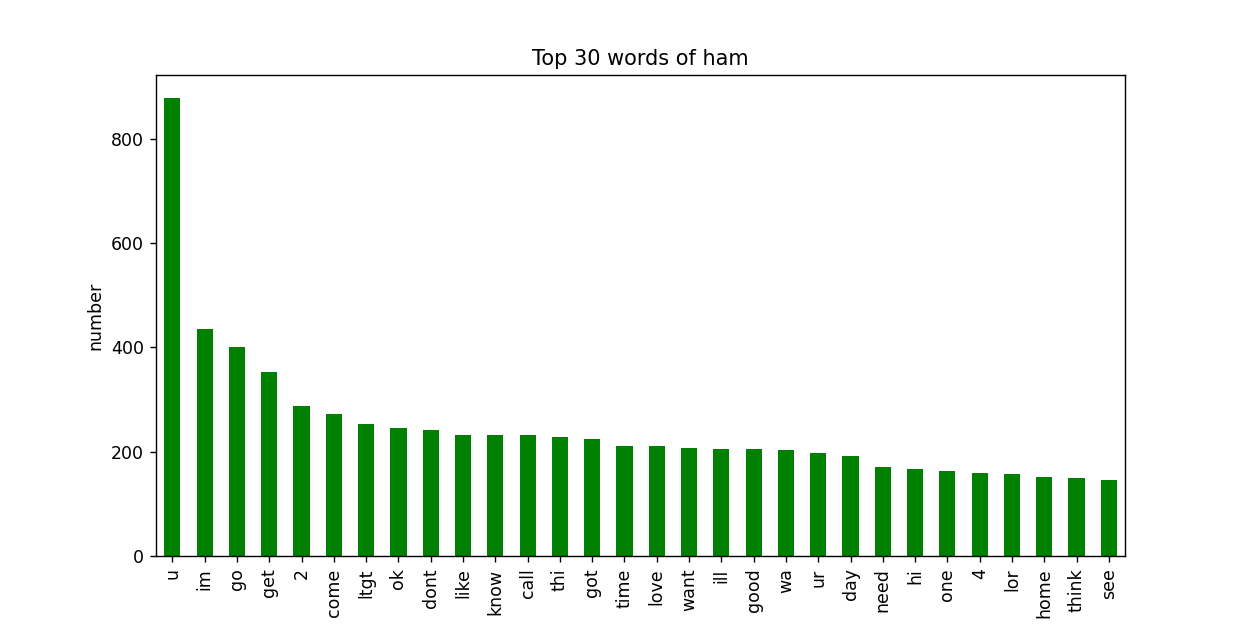

In [30]:
#lets plot the frequency of message with top 30 words of ham(not spam)

%matplotlib notebook
data1.plot.bar(legend = False, color = 'green',figsize = (10,5))
y_pos = np.arange(len(data1["words of ham"]))
plt.xticks(y_pos, data1["words of ham"])
plt.title('Top 30 words of ham')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

Graph for top 30 words of spam

<IPython.core.display.Javascript object>


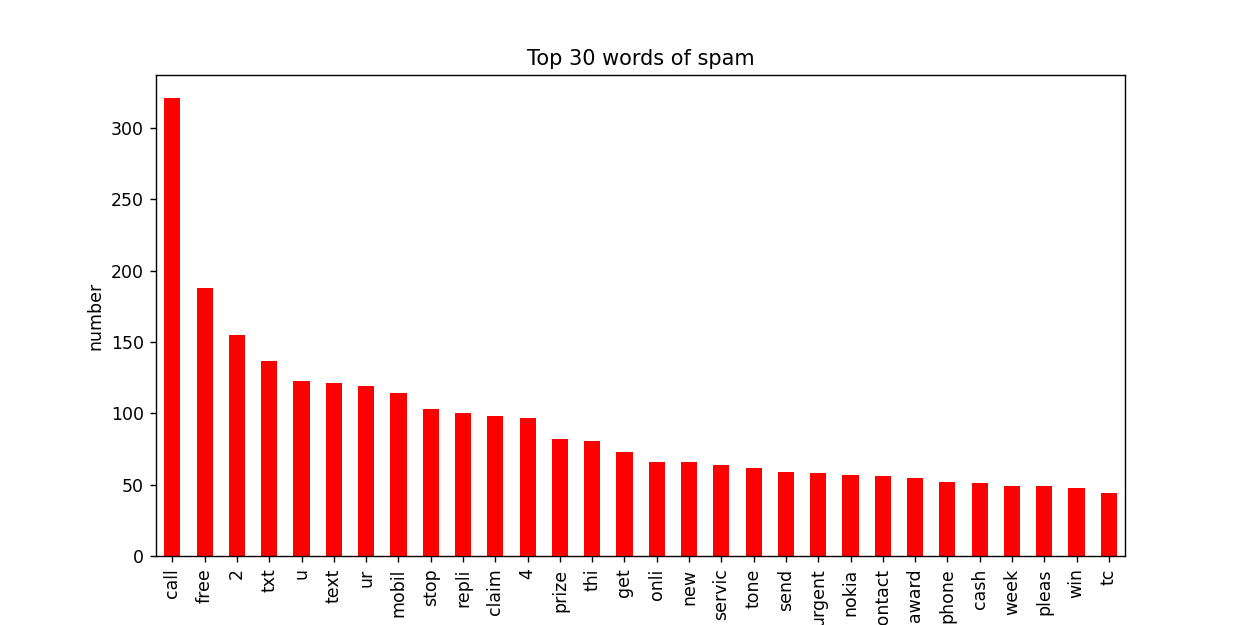

In [31]:
#lets plot the frequency of message with top 30words of spam

data2.plot.bar(legend = False, color = 'red', figsize = (10,5))
y_pos = np.arange(len(data2["words of spam"]))
plt.xticks(y_pos, data2["words of spam"])
plt.title('Top 30 words of spam')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

In [32]:
# Creating inputs to algorithm
X = df['text']
y = df['target']

In [33]:
# Let's divide the data into train and test set. We will take 20% of data as test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)


# Logistic Regression Model (n-grams) Fitting
Using a logistic regression I further include the use of ngrams which allow the model to take into account groups of words, of max size 5, when considering whether a message is spam.

Note:-

The CountVectorizer method automatically converts all tokenized words to their lower case form so that it does not treat words like 'He' and 'he' differently. It does this using the lowercase parameter which is by default set to True.

It also ignores all punctuation so that words followed by a punctuation mark (for example: 'hello!') are not treated differently than the same words not prefixed or suffixed by a punctuation mark (for example: 'hello').



In [34]:
vect = CountVectorizer(min_df=5, ngram_range=(2,5), analyzer='char_wb')
vect.fit(X_test)

CountVectorizer(analyzer='char_wb', min_df=5, ngram_range=(2, 5))

In [35]:
#defining an additional function
def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """                                                
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [36]:
# fit and Transform training datad

X_train_vect = vect.transform(X_train)

X_train_vect = add_feature(X_train_vect, [len(x) for x in X_train])
X_train_vect = add_feature(X_train_vect, [sum(char.isnumeric() for char in x) for x in X_train])
X_train_vect = add_feature(X_train_vect, X_train.str.count('\W'))

In [37]:
# Transform test data

X_test_vect = vect.transform(X_test)

X_test_vect = add_feature(X_test_vect, [len(x) for x in X_test])
X_test_vect = add_feature(X_test_vect, [sum(char.isnumeric() for char in x) for x in X_test])
X_test_vect = add_feature(X_test_vect, X_test.str.count('\W'))

### Run Logistic Regression

In [38]:
# logisticregression creation and model fitting
log= LogisticRegression(C=0.01,solver='liblinear')
log.fit(X_train_vect, y_train)

LogisticRegression(C=0.01, solver='liblinear')

In [39]:
## Chain all of the steps using imbalance pipeline module
clf = Pipeline([('vectorization',vect),
                ('lor',log)])

# Building model pipelines and fiting model:-


A machine learning pipeline is used to help automate machine learning workflows. These pipelines operate by enabling a sequence of data to be transformed and correlated together in a model that can be tested and evaluated all in a single code step.

In [40]:
# Building the piplines
clf.fit(X_train, y_train)

Pipeline(steps=[('vectorization',
                 CountVectorizer(analyzer='char_wb', min_df=5,
                                 ngram_range=(2, 5))),
                ('lor', LogisticRegression(C=0.01, solver='liblinear'))])

In [47]:
#CALCULATION ON CROSSS-VADIDATION

from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_train, y_train, cv=10) 
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.97826087 0.97826087 0.96618357 0.97826087 0.98792271 0.97820823
 0.97820823 0.98789346 0.97820823 0.99031477]


In [48]:
# minimu and max , average of 
scores = pd.Series(scores)
scores.min(), scores.mean(), scores.max()

(0.966183574879227, 0.9801721818670973, 0.9903147699757869)

so,our range of accuracy is between 0.96 to 0.99 but 0.97 on average

In [53]:
# compute model accuracy
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9893591293833132
0.9806576402321083


In [45]:
#predict the value
clf_predicted = clf.predict(X_test)

Accuracy of log model is 98.07%


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       885
           1       1.00      0.87      0.93       149

    accuracy                           0.98      1034
   macro avg       0.99      0.93      0.96      1034
weighted avg       0.98      0.98      0.98      1034





<IPython.core.display.Javascript object>


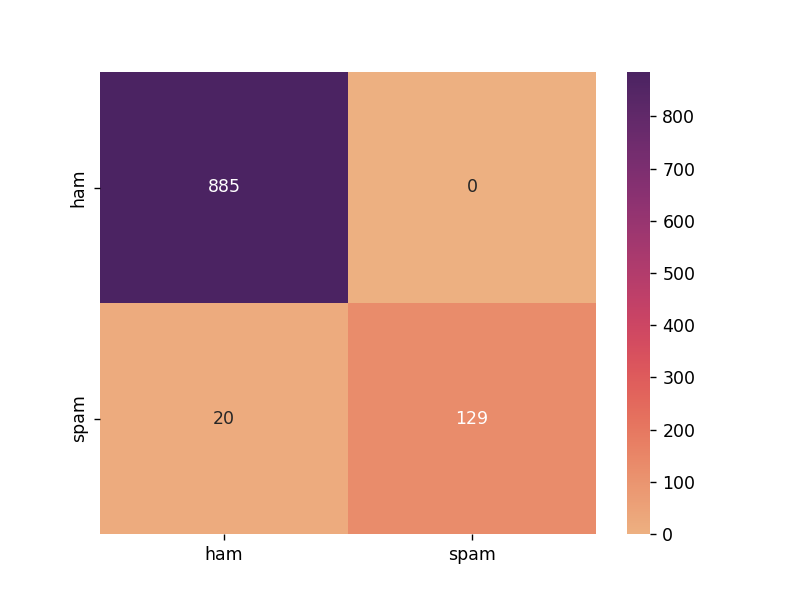

In [47]:
#accuracy of model
# Compute confusion matrix
acc_log = accuracy_score(y_test,clf_predicted)
print(f"Accuracy of log model is {np.round(acc_log*100,2)}%")
print('\n')
print(classification_report(y_test,clf_predicted))
print('\n')

ax=plt.subplot()
sns.heatmap(confusion_matrix(y_test,clf_predicted),annot = True,cmap='flare',fmt='g',ax=ax)

ax.xaxis.set_ticklabels(['ham', 'spam'])
ax.yaxis.set_ticklabels(['ham', 'spam'])
plt.show()

<IPython.core.display.Javascript object>


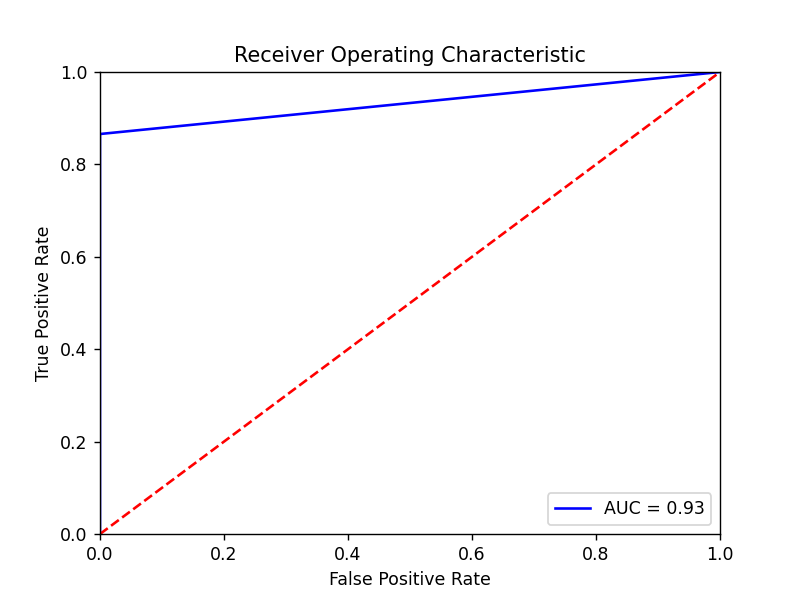

In [48]:
# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, clf_predicted)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Logistic Regression Model (n-grams) Evaluation
This results in the following:

AUC score of 93.00%

TPR of 86.57%

Specificity of 1.00%

FPR of 0%

In [49]:
tn, fp, fn, tp = confusion_matrix(y_test, clf_predicted).ravel()
print(pd.DataFrame(confusion_matrix(y_test, clf_predicted),
             columns=['Predicted Spam', "Predicted Ham"], index=['Actual Spam', 'Actual Ham']))
print(f'\nTrue Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')
print()
print()
print()
print(f'True Positive Rate: { (tp / (tp + fn))}')
print(f'Specificity: { (tn / (tn + fp))}')
print(f'False Positive Rate: { (fp / (fp + tn))}')

             Predicted Spam  Predicted Ham
Actual Spam             885              0
Actual Ham               20            129

True Positives: 129
False Positives: 0
True Negatives: 885
False Negatives: 20



True Positive Rate: 0.8657718120805369
Specificity: 1.0
False Positive Rate: 0.0


this is the calculation for the True postive rate and specificity , false postive rating.

# Conclusion:-


In [62]:
k=clf.predict(["free entri 2 wkli comp win fa cup final tkt 21st may 2005 text fa 87121 receiv entri questionstd txt ratetc appli 08452810075over18"])
print(k)

[1]


In [61]:
p=clf.predict(["freemsg hey darl 3 week word back id like fun still tb ok xxx std chg send å£150 rcv	"])
print(p)

[0]


In [64]:
j=clf.predict(["winner valu network custom select receivea å£900 prize reward claim call 09061701461 claim code kl341 valid 12 hour onli	"])
print(j)

[1]


This data frame gave an accuracy of 98% which is much good model.

By seeing that we can conclude what is ham and what is spam 

So, "0" tells us that its ham "1" tells us its spam.

You can know any kind of text weather its spam or ham for any given set of data or any random texts.



# Reference:-


https://notebook.community/georgetown-analytics/machine-learning/examples/mjiapalucci/SpamFilter

https://www.kaggle.com/code/snehithatiger/spam-or-ham-classification/notebook

https://towardsdatascience.com/create-a-sms-spam-classifier-in-python-b4b015f7404b

https://www.geeksforgeeks.org/sms-spam-detection-using-tensorflow-in-python/
   